In [1]:
import json
import logging
from pathlib import Path
from pprint import pprint

import jsonlines
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from tqdm import tqdm, trange

logging.disable(logging.ERROR)
cmap = mpl.colormaps["Set2"].colors


2023-03-21 10:18:48.215007: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-21 10:18:49.876800: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/matias/RECVIS:
2023-03-21 10:18:49.876927: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/matias/RECVIS:
2023-03-21 10:18:49.876933: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-T

In [2]:
def extract_metric_from_tf_events(path):
    try:
        event_acc = EventAccumulator(path)
        event_acc.Reload()
        scalars = event_acc.Tags()["scalars"]
        df_list = []
        for scalar in scalars:
            _, step_nums, vals = zip(*event_acc.Scalars(scalar))
            _df = pd.DataFrame([step_nums, vals], index=["step", scalar]).T.set_index(
                "step"
            )
            df_list.append(_df[~_df.index.duplicated(keep="last")])
        df = pd.concat(df_list, axis=1)
        df = df[~df.index.duplicated(keep="last")]
        assert len(df.index) == len(np.unique(df.index))
    except ValueError:
        return None
    return df


def retrieve_metrics_from_logdir(logdir):
    df_list = {}
    events_files = [f for f in logdir.glob("**/*/*events*") if f.is_file()]
    for event_file in tqdm(events_files):
        current_df = extract_metric_from_tf_events(str(event_file))
        if current_df is None:
            continue
        current_df["step"] = current_df.index
        df_list[event_file.parent.stem] = current_df
    return df_list


In [3]:
directory_path = Path("output")
df_list = retrieve_metrics_from_logdir(directory_path)


100%|██████████| 11/11 [00:21<00:00,  1.95s/it]


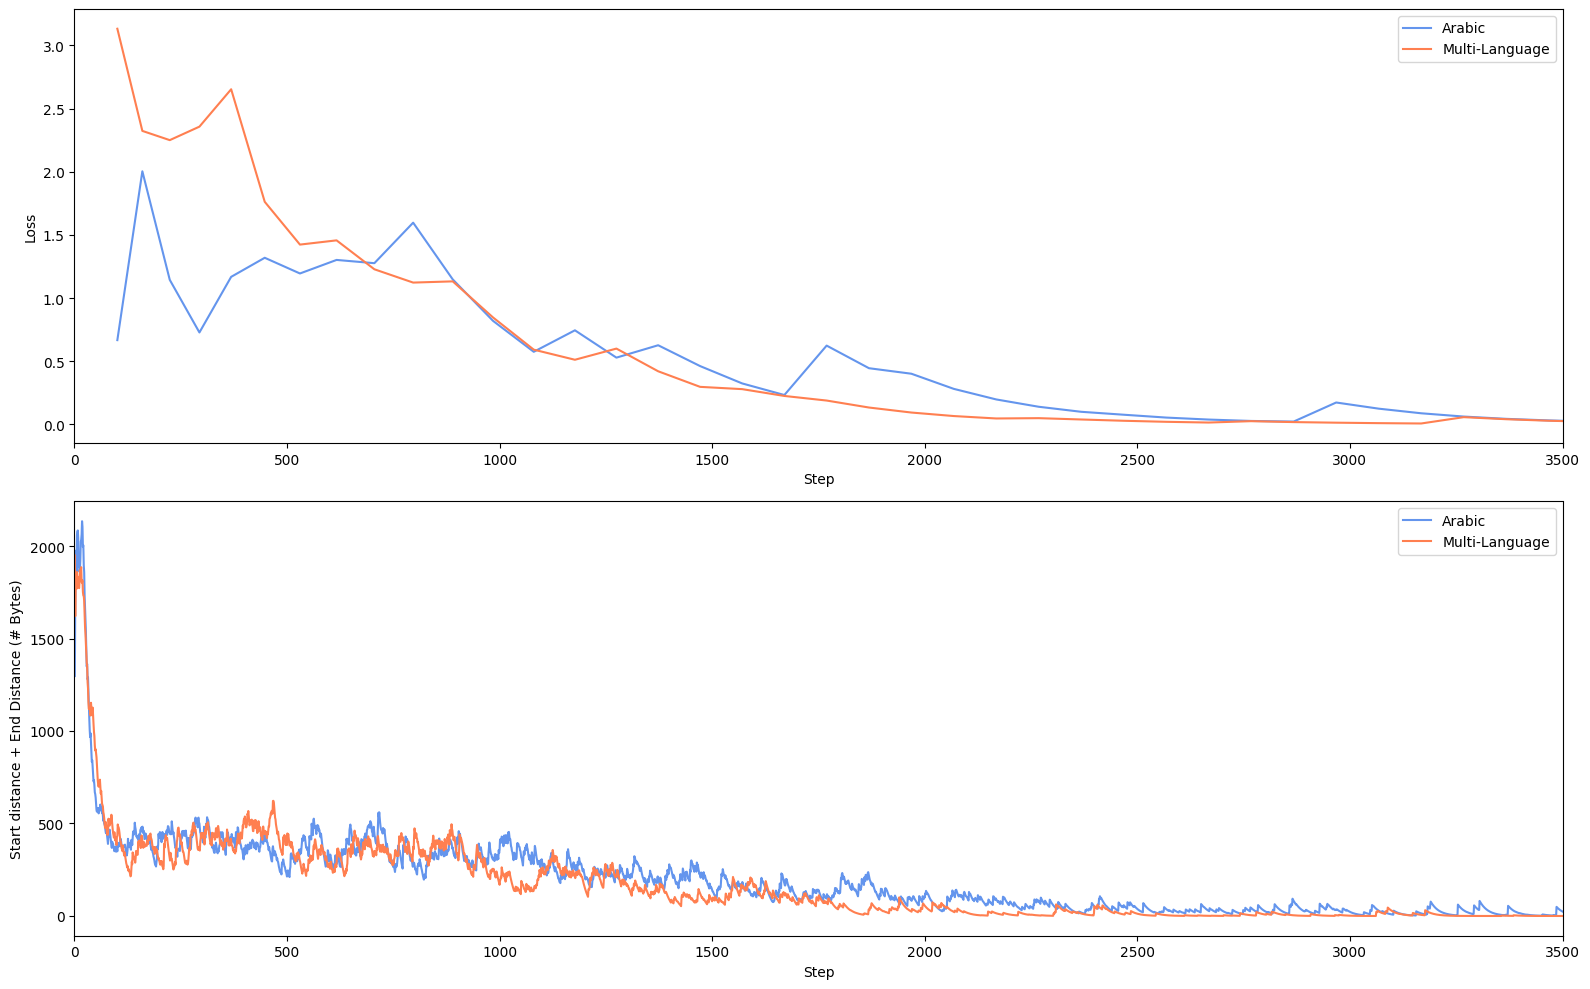

In [5]:
labels = ["Arabic", "Multi-Language"]
colors = [
    "cornflowerblue",
    "coral",
]
fig, axs = plt.subplots(2, 1, figsize=(16, 10))

columns = {"10_A_c": "loss", "10_M_c": "loss"}
for idx, (df_name, col_name) in enumerate(columns.items()):
    smooth_df = df_list[df_name].dropna().ewm(alpha=0.3).mean()
    sns.lineplot(data=smooth_df, x="step", y=col_name, ax=axs[0], label=labels[idx], color=colors[idx])
    axs[0].set_ylabel("Loss")
    axs[0].set_xlabel("Step")
    axs[0].set_xlim([0, 3500])

columns = {"10_A_c": "end_distance", "10_M_c": "end_distance"}
for idx, (df_name, col_name) in enumerate(columns.items()):
    smooth_df = (df_list[df_name]["end_distance"] + df_list[df_name]["start_distance"]).ewm(alpha=0.05).mean()
    sns.lineplot(data=smooth_df, x=smooth_df.index, y=smooth_df, ax=axs[1], label=labels[idx], color=colors[idx])
    axs[1].set_ylabel("Start distance + End Distance (# Bytes)")
    axs[1].set_xlabel("Step")
    axs[1].set_xlim([0, 3500])
plt.tight_layout()
plt.savefig("figures/distance_c.jpg", dpi=300)


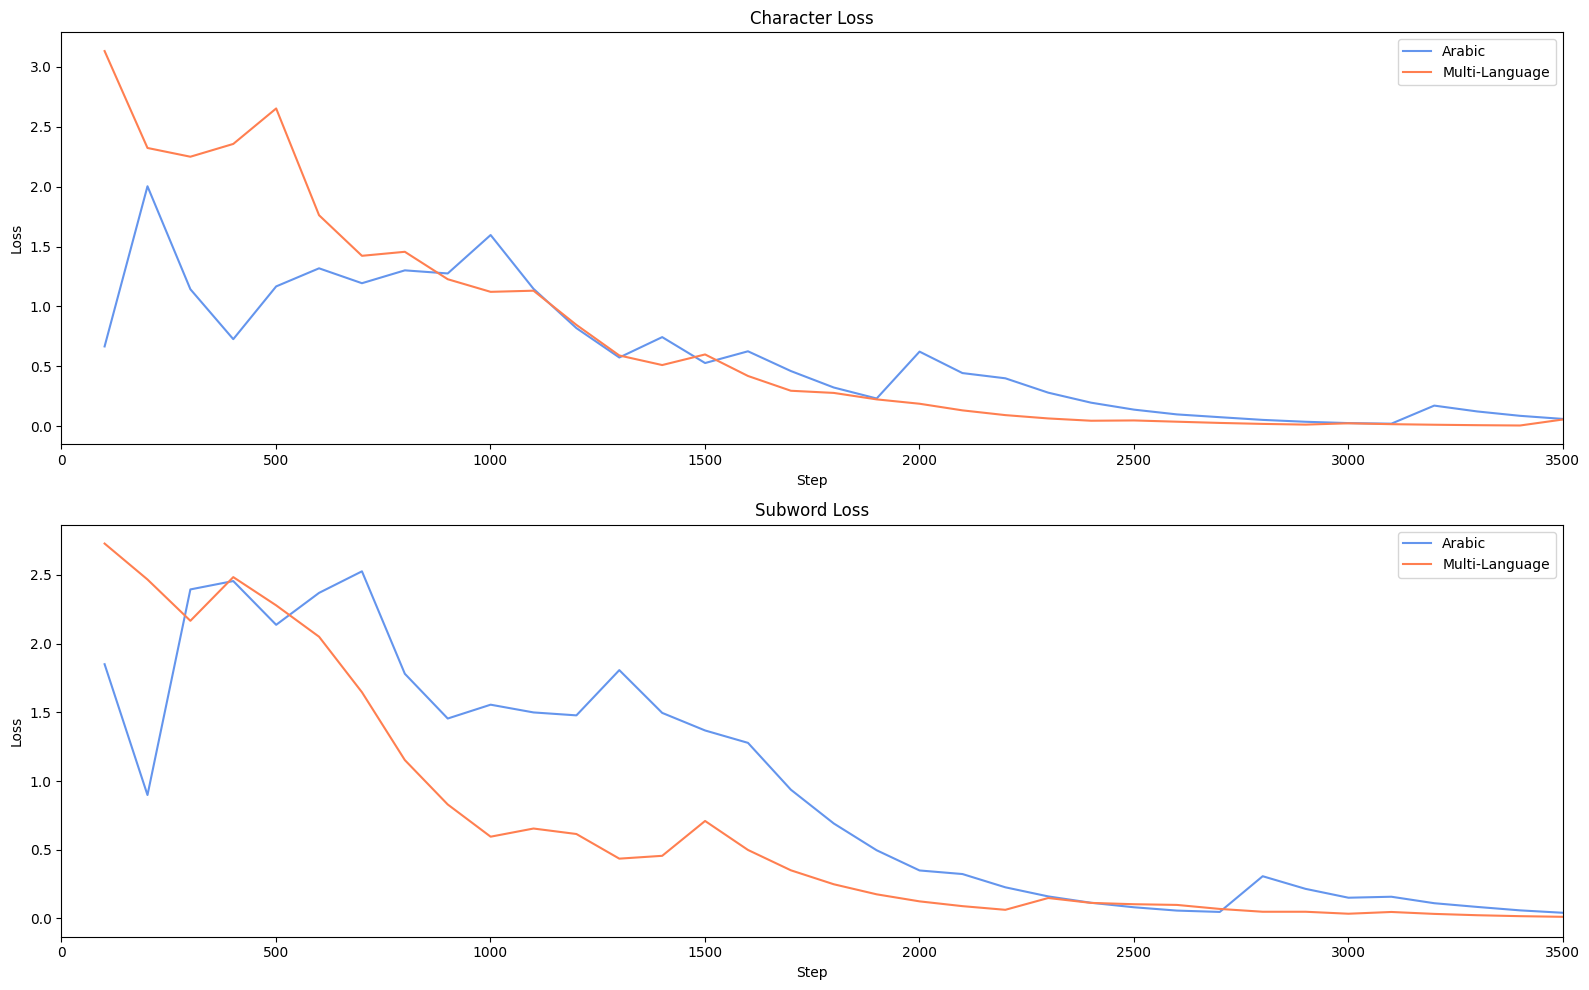

In [7]:
labels = ["Arabic", "Multi-Language"]
colors = [
    "cornflowerblue",
    "coral",
]
fig, axs = plt.subplots(2, 1, figsize=(16, 10))

columns = {"10_A_c": "loss", "10_M_c": "loss"}
for idx, (df_name, col_name) in enumerate(columns.items()):
    df = df_list[df_name][col_name].dropna()
    smooth_df = df.ewm(alpha=0.3).mean()
    sns.lineplot(data=smooth_df, ax=axs[0], label=labels[idx], color=colors[idx])
    axs[0].set_ylabel("Loss")
    axs[0].set_xlabel("Step")
    axs[0].set_title("Character Loss")
    axs[0].set_xlim([0, 3500])

columns = {"10_A_s": "loss", "10_M_s": "loss"}
for idx, (df_name, col_name) in enumerate(columns.items()):
    df = df_list[df_name][col_name].dropna()
    smooth_df = df.ewm(alpha=0.3).mean()
    sns.lineplot(data=smooth_df, ax=axs[1], label=labels[idx], color=colors[idx])
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Step")
    axs[1].set_title("Subword Loss")
    axs[1].set_xlim([0, 3500])

plt.tight_layout()
plt.savefig("figures/loss.jpg", dpi=300)


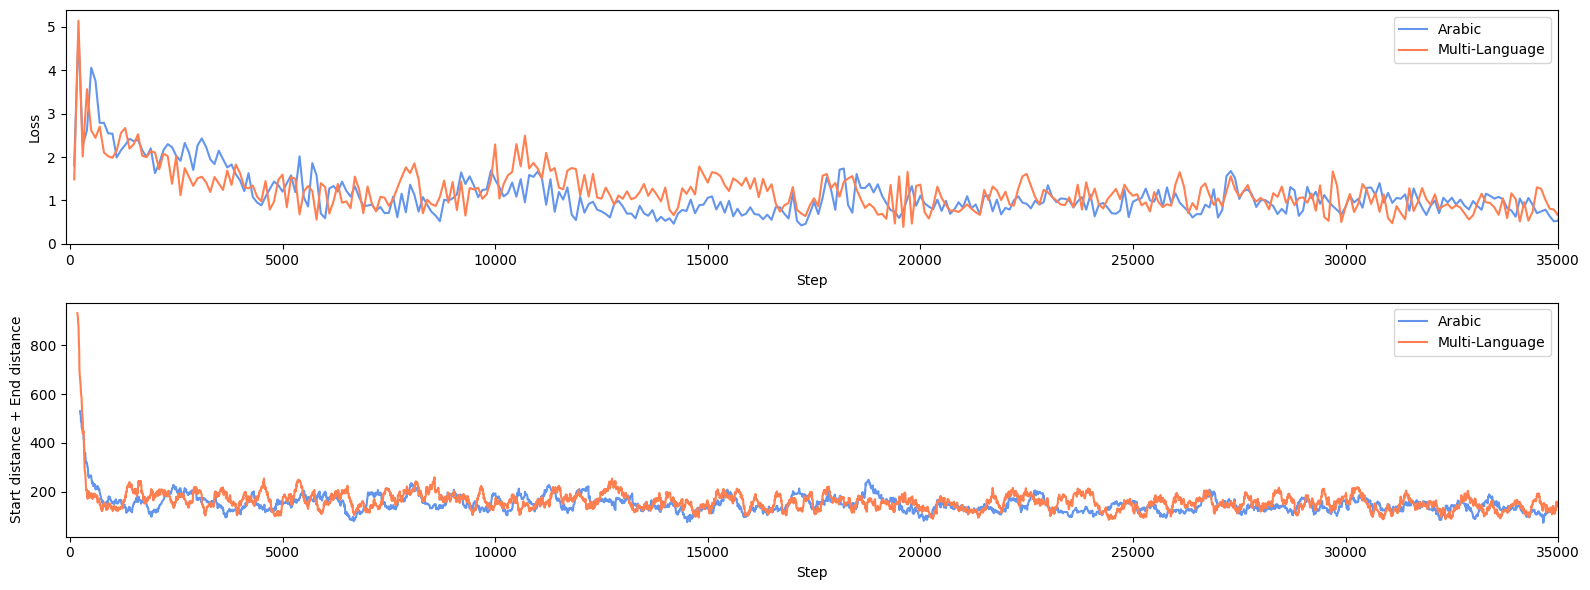

In [8]:
labels = ["Arabic", "Multi-Language"]
colors = [
    "cornflowerblue",
    "coral",
]
fig, axs = plt.subplots(2, 1, figsize=(16, 6))

columns = {"1_A_c": "loss", "1_M_c": "loss"}
for idx, (df_name, col_name) in enumerate(columns.items()):
    df = df_list[df_name][col_name].dropna()
    smooth_df = df.ewm(alpha=0.2).mean()
    sns.lineplot(data=smooth_df, ax=axs[0], label=labels[idx], color=colors[idx])
    axs[0].set_ylabel("Loss")
    axs[0].set_xlabel("Step")
    axs[0].set_xlim([-100, 35000])

columns = {"1_A_c": "loss", "1_M_c": "loss"}
for idx, (df_name, col_name) in enumerate(columns.items()):
    df = (
        df_list[df_name]["start_distance"].rolling(50).mean()
    )  # + df_list[df_name]["end_distance"]
    smooth_df = df  # .ewm(alpha=0.01).mean()
    sns.lineplot(data=smooth_df, ax=axs[1], label=labels[idx], color=colors[idx])
    axs[1].set_ylabel("Start distance + End distance")
    axs[1].set_xlabel("Step")
    axs[1].set_xlim([-100, 35000])

plt.tight_layout()
plt.savefig("figures/large_loss_distance.jpg", dpi=300)


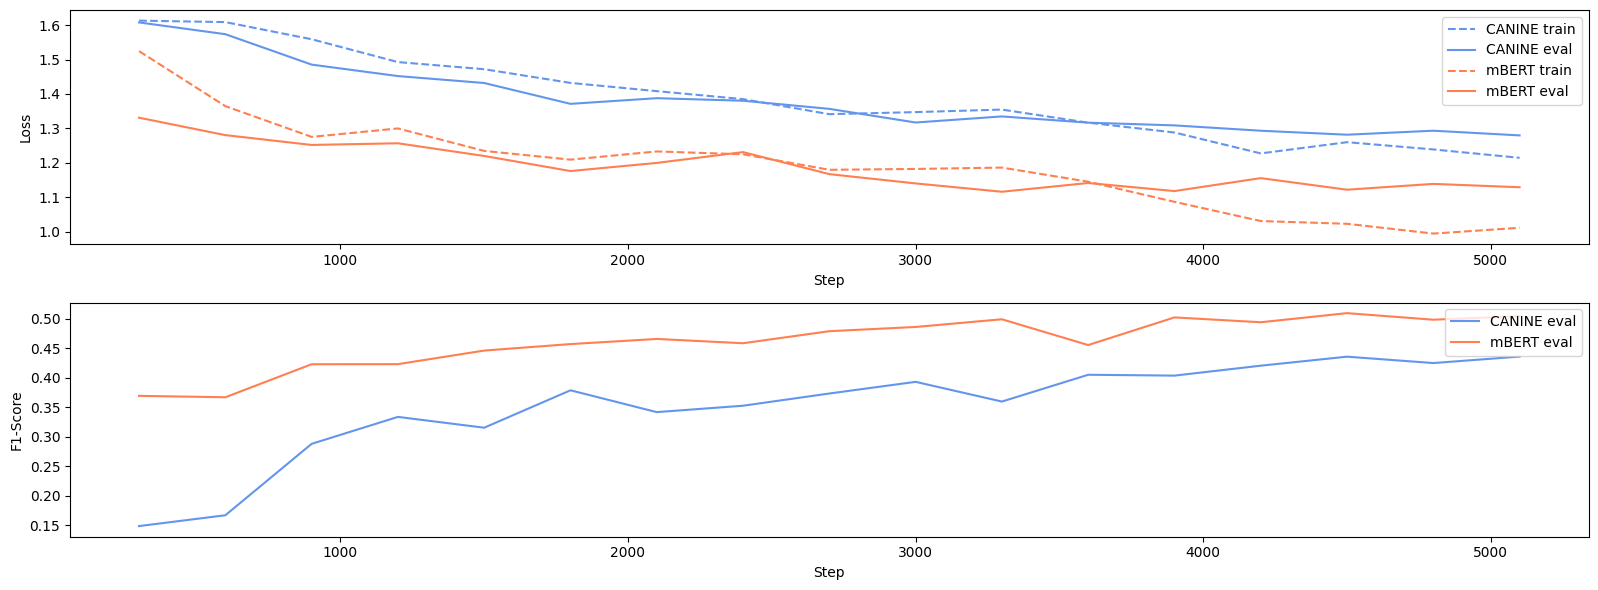

In [12]:
labels = ["CANINE", "mBERT"]
colors = [
    "cornflowerblue",
    "coral",
]

fig, axs = plt.subplots(2, 1, figsize=(16, 6))

columns = {
    "1_Canine_c": ["train/loss", "eval/loss"],
    "1_Bert": ["train/loss", "eval/loss"],
}
for idx, (df_name, col_name) in enumerate(columns.items()):
    for idx_loss, loss_name in enumerate(col_name):
        df = df_list[df_name][loss_name].dropna()
        # smooth_df = df.ewm(alpha=0.2).mean()
        sns.lineplot(
            data=df,
            ax=axs[0],
            label=labels[idx] + " " + loss_name.split("/")[0],
            linestyle=["--", "-" ][idx_loss],
            color=colors[idx]
        )
    axs[0].set_ylabel("Loss")
    axs[0].set_xlabel("Step")
axs[0].legend(loc="upper right")

columns = {"1_Canine_c": "eval/f1", "1_Bert": "eval/f1"}
for idx, (df_name, col_name) in enumerate(columns.items()):
    df = df_list[df_name][col_name].dropna()
    # smooth_df = df.ewm(alpha=0.01).mean()
    sns.lineplot(data=df, ax=axs[1], label=labels[idx] + " " + col_name.split("/")[0], color=colors[idx])
    axs[1].set_ylabel("F1-Score")
    axs[1].set_xlabel("Step")
axs[1].legend(loc="upper right")

plt.tight_layout()
plt.savefig("figures/comparison_canine_mbert.jpg", dpi=300)


In [4]:
dataset_path = "dev_samples/tydiqa-v1.0-dev_arabic.jsonl"
dataset = {}
predictions_path = "predictions/pred_M_arabic.jsonl"
predictions = {}

with jsonlines.open(dataset_path) as ds:
    for sample in tqdm(ds.iter(skip_invalid=True)):
        _id = sample.pop("example_id")
        assert _id not in dataset.keys()
        sample.pop("document_plaintext")
        dataset[_id] = sample

with jsonlines.open(predictions_path) as ds:
    for sample in tqdm(ds.iter(skip_invalid=True)):
        _id = sample.pop("example_id")
        assert _id not in predictions.keys()
        predictions[_id] = sample


1380it [00:00, 1784.92it/s]
1380it [00:00, 26335.46it/s]


In [5]:
def compute_metrics_recall_from_span(annotation, prediction):
    if (
        annotation["plaintext_end_byte"] == -1
        and annotation["plaintext_start_byte"] == -1
    ):
        raise KeyError
    length_prediction = (
        prediction["minimal_answer"]["end_byte_offset"]
        + 1
        - prediction["minimal_answer"]["start_byte_offset"]
    )
    length_annotation = (
        annotation["plaintext_end_byte"] + 1 - annotation["plaintext_start_byte"]
    )
    true_positive = np.sum(
        np.isin(
            np.arange(
                prediction["minimal_answer"]["start_byte_offset"],
                prediction["minimal_answer"]["end_byte_offset"] + 1,
            ),
            np.arange(
                annotation["plaintext_start_byte"], annotation["plaintext_end_byte"] + 1
            ),
        )
    )
    # print(true_positive, length_prediction, length_annotation)
    precision = true_positive / length_prediction
    recall = true_positive / length_annotation
    f1 = 2 * (recall * precision) / (recall + precision)
    return precision, recall, f1


def compute_metrics_recall_from_all_spans(annotations, prediction):
    metrics = []
    for annotation in annotations:
        try:
            metric = compute_metrics_recall_from_span(
                annotation["minimal_answer"], prediction
            )
            metrics.append(metric)
        except KeyError as e:
            continue
    if len(metrics) == 0:
        return is_null_consensus_answer(annotations), None, None, None
    sorted_metrics = sorted(metrics, key=lambda x: x[2])
    return is_null_consensus_answer(annotations), *sorted_metrics[-1]


def compute_passage_equality(annotations, prediction):
    if all(
        [
            annotation["passage_answer"]["candidate_index"] == -1
            for annotation in annotations
        ]
    ):
        return None
    else:
        return (
            any(
                [
                    prediction["passage_answer_index"]
                    == annotation["passage_answer"]["candidate_index"]
                    for annotation in annotations
                ]
            )
            + 0.0
        )


def is_null_consensus_answer(annotations):
    return (
        np.sum(
            [
                annotation["minimal_answer"]["plaintext_end_byte"] == -1
                for annotation in annotations
            ]
        )
        >= 2
    )


def is_null_consensus_passage(annotations):
    return (
        np.sum(
            [
                annotation["passage_answer"]["candidate_index"] == -1
                for annotation in annotations
            ]
        )
        >= 2
    )


def compute_passage_equality(annotations, prediction):
    return (
        is_null_consensus_passage(annotations),
        (
            any(
                [
                    prediction["passage_answer_index"]
                    == annotation["passage_answer"]["candidate_index"]
                    for annotation in annotations
                ]
            )
            + 0.0
        ),
        prediction["passage_answer_index"] >= 0,
    )


In [6]:
denom_precision = 0
denom_recall = 0
metrics = []
for idx, (example_id, prediction) in tqdm(enumerate(predictions.items())):
    example = dataset[example_id]
    (
        null_consensus_answer,
        precision_answer,
        recall_answer,
        f1_answer,
    ) = compute_metrics_recall_from_all_spans(example["annotations"], prediction)
    null_consensus_passage, good, non_null_answer = compute_passage_equality(
        example["annotations"], prediction
    )
    denom_precision += non_null_answer
    denom_recall += 1 - null_consensus_passage
    metrics.append(
        {
            "precision": precision_answer,
            "recall": recall_answer,
            "f1": f1_answer,
            "null_consensus_answer": null_consensus_answer,
            "null_consensus_passage": null_consensus_passage,
            "good_passage": good,
            "minimal_answer_score": prediction["minimal_answer_score"],
            "passage_answer_score": prediction["passage_answer_score"],
            "example_id": example_id,
        }
    )
metrics = pd.DataFrame.from_records(metrics)


0it [00:00, ?it/s]/tmp/ipykernel_1122/3619935598.py:29: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * (recall * precision) / (recall + precision)
1380it [00:00, 4556.36it/s]


In [7]:
a = metrics[~metrics["null_consensus_passage"]]["good_passage"].sum()
p = a / denom_precision
r = a / denom_recall
f1 = 2 * (r * p) / (r + p)
p, r, f1


(0.605072463768116, 0.7929724596391263, 0.6863953966296753)

In [8]:
metrics[~metrics["null_consensus_answer"]].mean()


precision                 5.980713e-01
recall                    5.774946e-01
f1                        8.874418e-01
null_consensus_answer     0.000000e+00
null_consensus_passage    0.000000e+00
good_passage              8.286015e-01
minimal_answer_score      1.098397e+01
passage_answer_score      1.098397e+01
example_id                7.044292e+16
dtype: float64

In [81]:
metrics.shape


(1380, 9)